## Network model

This is an example of how to use the network model. The only thing should do is modify the parameters named "log_dir" and "model_dir" to the directory path where the repository located. After that, read you preprocessed data ([see an example](./exam_preprocessing.ipynb)) and run the following lines step by step. Note that if you run this scripy on Jupyter, you must restart the kernel every time to avoid the namescope conflicts in tensorflow.

In [1]:
name = 'ResNN_004'
batch_size = 64
model_basename = 'ResNN4-SDSS'
train_steps = 50000
import sys; sys.argv=['', 
                      '--log_dir', '/home/mtx/git/SDSSV_Classifiers/log',  # modify it to 'path/to/repository/log'
                      '--model_dir', '/home/mtx/git/SDSSV_Classifiers/model', # modify it to 'path/to/repository/model'
                      '--batch_size', '%d'%batch_size,
                      '--model_basename', model_basename,
                      '--train_steps', '%d'%train_steps,
                      '--learning_rate', '1e-3',
                      '--Is_BN', 'True',
                      '--weight_decay','5e-6',
                     ];
del sys
import os

In [2]:
import tensorflow as tf
import numpy as np
import tqdm
tf.logging.set_verbosity(tf.logging.INFO)
from tftool.main import Main

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class RunWapper(Main):
    def __init__(self, *args, **kwargs):
        super(RunWapper, self).__init__(*args, **kwargs)
        self.data_shape = 3000
    def __call__(self):
        """an example for constructing network model"""
        self.train_filenames = ["/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/training.tfrecords"]
        self.valid_filenames = ["/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/valid.tfrecords"]
        self.Is_training = tf.placeholder(tf.bool,shape=[],name='is_train')
        x, y_ = self.loaddata(repeat=10,shuffle=True)
        net = self.inference(x, is_training=self.Is_training)
        loss = self.Loss_fn(self, net=net, y_=y_)
        train_op = self.optimizer(loss, gclip=1.0)
        self.train(loss, train_op)  
    
    def eval(self, flux, label):
        BS = self.FLAGS.batch_size
        label = label.astype(np.int32)
        print flux.dtype, flux.shape
        print label.dtype, label.shape
        if label.shape[0]%BS == 0:
            loop_num = label.shape[0]//BS
        else:
            loop_num = label.shape[0]//BS + 1
        print "loop number: %d"%loop_num
        #------------------------------------------------------------
        x = tf.placeholder(tf.float32, shape=[None, self.data_shape])
        y_ = tf.placeholder(tf.int32, shape=[None])
        net = self.inference(x, is_training=False)
        loss = self.Loss_fn(self, net=net, y_=y_)
        prob = tf.get_collection('prob')[0]
        LOSS = []
        PROB = []
        with tf.Session(config=self.config) as sess:
            self.Saver = tf.train.Saver(max_to_keep=1)
            self.init_model(sess)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            for i in tqdm.tqdm(xrange(loop_num)):
                el, ep, = sess.run([loss, prob], 
                                   feed_dict={x:flux[i*BS:(i+1)*BS],
                                              y_:label[i*BS:(i+1)*BS]})
                LOSS.append(el)
                PROB.append(ep)
            coord.request_stop()
            coord.join(threads)
        LOSS = np.array(LOSS)
        PROB = np.vstack(PROB)
        return LOSS, PROB
dsc = RunWapper()
print dsc.FLAGS

INFO:tensorflow:(<class 'tftool.main.Main'>, <class 'tftool.Train.Train'>, <class 'tftool.Network.Model'>, <class 'tftool.InputPipeline.InputPipeline'>, <class 'tftool.Utils.Toolkit'>, <class 'tftool.Base.Base'>, <type 'object'>)
Namespace(Is_BN=True, batch_size=64, learning_rate=0.001, log_dir='/home/mtx/git/SDSSV_Classifiers/log', model_basename='ResNN4-SDSS', model_dir='/home/mtx/git/SDSSV_Classifiers/model', train_steps=50000, weight_decay=5e-06)


---
## Evaluation

Here, load your preprocessed data. Before input the data into network, you should centralize and normalize the flux like below.

In [4]:
data_hs = np.load('/nfs/P100/SDSSV_Classifiers/processed_dataset/dataset/test_hotstars.npy')
data_wd = np.load('/nfs/P100/SDSSV_Classifiers/processed_dataset/dataset/test_wd.npy')
print data_hs.shape, data_wd.shape
dataset = np.hstack([data_hs, data_wd])
print dataset.shape, dataset.dtype
mean = np.load(os.path.join(dsc.FLAGS.model_dir,'Norm_mu.npy'))
std = np.load(os.path.join(dsc.FLAGS.model_dir,'Norm_std.npy'))
dataset['flux_norm'] = (dataset['flux_norm']-mean)/std

(86,) (784,)
(870,) [('index', '<i4'), ('label', '<i4'), ('flux_norm', '<f4', (3000,))]


In [5]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint'), "w") as f:
    cp = 'model_checkpoint_path: "{}"\n'.format(os.path.join(dsc.FLAGS.model_dir,"ResNN4-SDSS-49999"))
    f.writelines(cp)

The `prob` is the predicted probability of each type and you can get the largest probability type by `np.argmax`. Please note that the order of six probabilities is 'wdsb2', 'wd', 'yso', 'hotstars', 'fgkm', and 'cv'.

In [6]:
name_type = {'wdsb2': 0, 'wd': 1, 'yso': 2, 'hotstars': 3, 'fgkm': 4, 'cv': 5}

In [7]:
loss, prob = dsc.eval(dataset['flux_norm'], dataset['label'])

float32 (870, 3000)
int32 (870,)
loop number: 14
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 3000), dtype=float32)
INFO:tensorflow:==========ResNet_softmax==========
INFO:tensorflow:load variable from /home/mtx/git/SDSSV_Classifiers/model/ResNN4-SDSS-49999
INFO:tensorflow:Restoring parameters from /home/mtx/git/SDSSV_Classifiers/model/ResNN4-SDSS-49999


100%|██████████| 14/14 [00:01<00:00, 13.31it/s]


In [8]:
p_label = np.argmax(prob,axis=1)
labelarr = dataset['label']

### check result

I show the confusion matrix below.

In [12]:
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
params = {
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.figsize': [4.5, 4.5],
    #----------
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'image.cmap': 'jet',
    'legend.frameon':  False,
    'xtick.top': True,
    'ytick.right': True,
    #----------
    'lines.linewidth': 2.0,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.top': True, 
    'xtick.minor.bottom': True, 
    'ytick.minor.left': True, 
    'ytick.minor.right': True,
    #----------
    'lines.markeredgewidth': 0.5,
    'errorbar.capsize': 5.0,
   }
plt.rcParams.update(params)

In [10]:
m = np.c_[labelarr,p_label]
matrix = np.zeros([6,6],dtype=np.float32)
for i,j in m:
    matrix[i,j]+=1.

['wdsb2\n0', 'wd\n784', 'yso\n0', 'hotstars\n86', 'fgkm\n0', 'cv\n0']
['wdsb2\n0', 'wd\n714', 'yso\n0', 'hotstars\n156', 'fgkm\n0', 'cv\n0']


__main__:1: RuntimeWarning: divide by zero encountered in log10


([<matplotlib.axis.YTick at 0x7fa02c7cec10>,
 <a list of 6 Text yticklabel objects>)

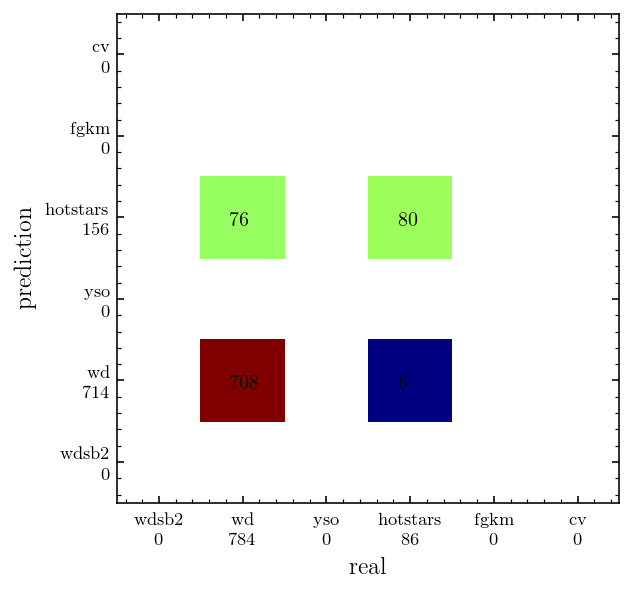

In [13]:
plt.pcolor(np.log10(matrix.T))
#plt.colorbar()
for i in xrange(6):
    for j in xrange(6):
        if matrix[i,j]!=0:
            plt.text(i+0.35,j+0.4,"%d"%np.round(matrix[i,j]),color='k')
plt.xlabel('real')
plt.ylabel('prediction')
ticks_real = ["{}\n{}".format(key,np.sum(labelarr==name_type[key])) for key in name_type.keys()]
ticks_pred = ["{}\n{}".format(key,np.sum(p_label==name_type[key])) for key in name_type.keys()]
print ticks_real
print ticks_pred
plt.xticks(np.array(name_type.values())+0.5,ticks_real)
plt.yticks(np.array(name_type.values())+0.5,ticks_pred)